## A simple example with training a basic MLP with PyTorch

Follow this guide if you want to install PyTorch locally: https://pytorch.org/get-started/locally/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

These are the PyToch modules

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

We will be using the same house price dataset.

In [3]:
houses = pd.read_csv("https://raw.githubusercontent.com/Ziqi-Li/GIS5122/main/data/seattle_data_cleaned.csv")

In [4]:
sampled = houses.sample(frac=0.2,random_state=1)

y = sampled.log_10_price.values.reshape(-1,1)

X = sampled[['bathrooms', 'sqft_living', 'sqft_lot', 'grade',
       'condition', 'waterfront', 'view', 'age', 'UTM_X', 'UTM_Y']]

Randomly split the data into 80% for training and 20% for testing.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

 For NN based models, we often need to apply a 'StandardScaler' to the data. Neurual nets usually are sensitive to the scale of the data so you need to standardize (or by other transformations) them. This is because the gradient descent nature of the optimization algorithm makes it sensitive to weights attached to the data that are overly small or large.

In [6]:
from sklearn.preprocessing import StandardScaler
# Scale the features

#Here we use a standard scaler that will make the data have mean of 0 and std of 1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In pytorch, data are stored in a special data structure which is called `tensor`, this is not much different than a `numpy` array.

In [7]:
# Convert the data into PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


It is often also convinent to use a `DataLoader` to feed/split data into the NN.

In [8]:
# Define a DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)






### Define a batch size, typical batch sizes are: 32, 64, 128, 256 or 512.

You also have the option to shuffle the data before splitting into batches. It is **recommanded for the training data** but **not for the testing data**. This is because shuffling training data can break the order in the data every epoch for a more robust model. However, when evaluating model on the test dataset, you may want to evaluate performance on the same fixed test dataset.

In [9]:
train_loader = DataLoader(train_data, batch_size=128,shuffle=True)

test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

### Define the MLP model

Usually an NN is defined in a class for modular re-use purpose.

Here we define a NN with the following structure:

10 (Input, our Xs) X 8(Hidden Layer 1) X 4(Hidden Layer 2) X 1 (Output, y)

This is saying we have 10 features for the house to predict the house's value. Hidden layers can defined with other parameters.

We are gonna use ReLu for hidden layer activation functions, and linear (no) for the activation function before the final output.

In [10]:

class RegressionMLP(nn.Module):
    def __init__(self, input_size):
        #Note: super() is a built-in function used to call methods defined in the parent class
        #Here we inherit the __init__() function from nn.Module.
        super(RegressionMLP, self).__init__()
    
        #NN sturtucre
        #input_size = # of features
        #10 X 8 X 4 X 1
        #fc refers to fully-connected layer
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
    
    def forward(self, x):
        #activation function -> ReLu
        f = nn.ReLU()
        x = f(self.fc1(x))
        x = f(self.fc2(x))
        # No activation function for the output layer in regression
        x = self.fc3(x)  
        return x

In [11]:
#define the model with our data
model = RegressionMLP(X_train.shape[1])

# Loss function - mean squared error
criterion = nn.MSELoss()

#As mentioned in class, adam is a pretty good optimizer, and learning rate=0.001 is a good starting point.
optimizer = optim.Adam(model.parameters(), lr=0.001)


Now we train our model. This involves running the NN forward and backward for # of epochs time. And we store the training loss and testing loss.

In [12]:
%%time

train_losses = []
val_losses = []

#Number of epochs
epochs = 1000
for epoch in range(epochs):
    #turn on training mode
    model.train()
    train_loss = 0
    #For each batch in our training dataset
    for X_batch, y_batch in train_loader:
        #reset gradients
        optimizer.zero_grad()
        #forward to get prediction
        y_pred = model(X_batch)
        #calculate loss
        loss = criterion(y_pred, y_batch)
        #backward to update weights/biases
        loss.backward()
        optimizer.step()
        #sum over loss for all the batches.
        train_loss += loss.item()
    
    #store the average loss
    train_losses.append(train_loss / len(train_loader))

    
    #turn on evaluation mode
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            #forward to get predicton
            y_pred = model(X_batch)
            #calculate loss on test data
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()
    #store the average loss
    val_losses.append(val_loss / len(test_loader))

    #print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}")

CPU times: user 11.1 s, sys: 86.4 ms, total: 11.2 s
Wall time: 11.2 s


It is also pretty often to plot loss vs. epoch. It is expected that the model will converge and further epochs will not improve model performance on the test dataset.

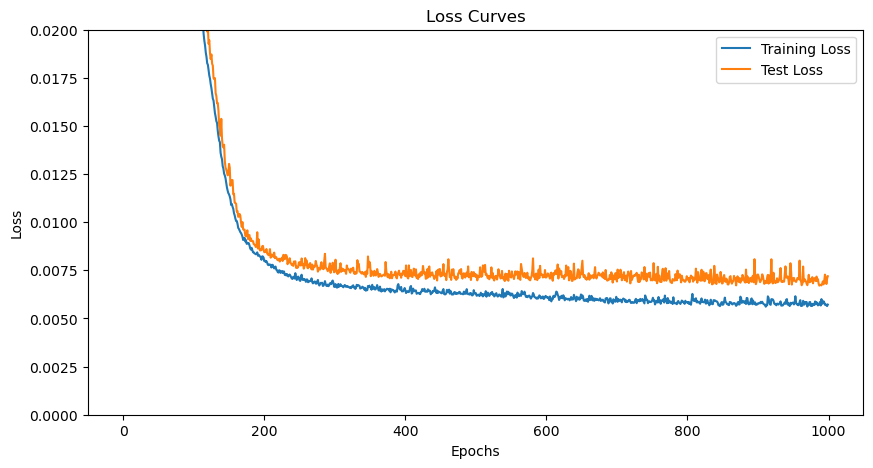

In [13]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Test Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.xlim(0,200)
plt.ylim(0,0.02)
plt.legend()
plt.show()

We can see that the test loss stays the same after ~400 epochs, while training loss continues to decrease slightly, this is an indication of overfitting if having too many epochs.

Calculate R2 for the test data.

In [14]:
from sklearn.metrics import r2_score

In [15]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    predictions = model(X_test_tensor)
    print("Model R2:",r2_score(y_test_tensor, predictions.numpy().reshape(-1)))

Model R2: 0.8537869393311385


In [16]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    predictions = model(X_train_tensor)
    print("Model R2:",r2_score(y_train_tensor, predictions.numpy().reshape(-1)))

Model R2: 0.8891486189149684
